In [1]:
# Description: Plot Figure 13 (Conditionally-averaged velocity and Reynolds stress profiles).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
from xarray import open_dataset, DataArray, concat
from dewaveADCP.utils import fourfilt
from os import system
from os.path import isfile

In [3]:
def ffilt_lp(da, dts, Tmax, Tmin, max_nanfrac=0.1):
    coords = da.coords
    wrk = da.values*np.nan
    nz, nt = wrk.shape
    for k in range(nz):
        aux = da.isel(z=k).values.copy()
        if (np.isnan(aux).sum()/nt)>nt*max_nanfrac:
            continue
        aux[np.isnan(aux)] = np.nanmean(aux)
        wrk[k,:] = fourfilt(aux, dts, Tmax, Tmin)

    return DataArray(wrk, coords=coords, dims=('z', 't'))


def crosscorr(x, y, nblks, maxlags=0, overlap=0, onesided=False, verbose=True):
    """
    Lag-N cross correlation averaged with Welch's Method.
    Parameters
    ----------
    x, y     : Arrays of equal length.
    nblks    : Number of blocks to average cross-correlation.
    maxlags  : int, default (0) calculates te largest possible number of lags,
               i.e., the number of points in each chunk.
    overlap  : float, fraction of overlap between consecutive chunks. Default 0.
    onesided : Whether to calculate the cross-correlation only at
               positive lags (default False). Has no effect if
               x and y are the same array, in which case the
               one-sided autocorrelation function is calculated.

    Returns
    ----------
    crosscorr : float array.
    """
    if x is y:
        auto = True
    else:
        auto = False
    x, y = np.array(x), np.array(y)
    nx, ny = x.size, y.size
    assert x.size==y.size, "The series must have the same length"

    nblks, maxlags = int(nblks), int(maxlags)
    ni = int(nx/nblks)               # Number of data points in each chunk.
    dn = int(round(ni - overlap*ni)) # How many indices to move forward with
                                     # each chunk (depends on the % overlap).

    if maxlags==0:
        if verbose:
            print("Maximum lag was not specified. Accomodating it to block size (%d)."%ni)
        maxlags = ni
    elif maxlags>ni:
        if verbose:
            print("Maximum lag is too large. Accomodating it to block size (%d)."%ni)
        maxlags = ni

    if onesided:
        lags = range(maxlags+1)
    else:
        lags = range(-maxlags, maxlags+1)

    # Array that will receive cross-correlation of each block.
    xycorr = np.zeros(len(lags))

    n=0
    il, ir = 0, ni
    while ir<=nx:
        xn = x[il:ir]
        yn = y[il:ir]

        # Calculate cross-correlation for current block up to desired maximum lag - 1.
        xn, yn = map(Series, (xn, yn))
        xycorr += np.array([xn.corr(yn.shift(periods=lagn)) for lagn in lags])

        il+=dn; ir+=dn
        n+=1

    # pandas.Series.corr(method='pearson') -> pandas.nanops.nancorr() ...
    # -> pandas.nanops.get_corr_function() -> np.corrcoef -> numpy.cov(bias=False as default).
    # So np.corrcoef() returns the UNbiased correlation coefficient by default
    # (i.e., normalized by N-k instead of N).

    xycorr /= n    # Divide by number of blocks actually used.
    ncap = nx - il # Number of points left out at the end of array.

    if verbose:
        print("")
        if ncap==0:
            print("No data points were left out.")
        else:
            print("Left last %d data points out (%.1f %% of all points)."%(ncap,100*ncap/nx))
        print("Averaged %d blocks, each with %d lags."%(n,maxlags))
        if overlap>0:
            print("Intended %d blocks, but could fit %d blocks, with"%(nblks,n))
            print('overlap of %.1f %%, %d points per block.'%(100*overlap,dn))
        print("")

    lags = np.array(lags)
    if auto and not onesided:
        fo = np.where(lags==0)[0][0]
        xycorr[fo+1:] = xycorr[fo+1:] + xycorr[:fo]
        lags = lags[fo:]
        xycorr = xycorr[fo:]

    fgud=~np.isnan(xycorr)
    if fgud.any():
        lags, xycorr = lags[fgud], xycorr[fgud]

    return lags, xycorr


def Tdecorr(Rxx, M=None, dtau=1., verbose=False):
    """
    USAGE
    -----
    Td = Tdecorr(Rxx)

    Computes the integral scale Td (AKA decorrelation scale, independence scale)
    for a data sequence with autocorrelation function Rxx. 'M' is the number of
    lags to incorporate in the summation (defaults to all lags) and 'dtau' is the
    lag time step (defaults to 1).

    The formal definition of the integral scale is the total area under the
    autocorrelation curve Rxx(tau):

    /+inf
    Td = 2 * |     Rxx(tau) dtau
    /0

    In practice, however, Td may become unrealistic if all of Rxx is summed
    (e.g., often goes to zero for data dominated by periodic signals); a
    different approach is to instead change M in the summation and use the
    maximum value of the integral Td(t):

    /t
    Td(t) = 2 * |     Rxx(tau) dtau
    /0

    References
    ----------
    e.g., Thomson and Emery (2014),
    Data analysis methods in physical oceanography,
    p. 274, equation 3.137a.

    Gille lecture notes on data analysis, available
    at http://www-pord.ucsd.edu/~sgille/mae127/lecture10.pdf
    """
    Rxx = np.array(Rxx)
    C0 = Rxx[0]
    N = Rxx.size # Sequence size.

    # Number of lags 'M' to incorporate in the summation.
    # Sum over all of the sequence if M is not chosen.
    if not M:
        M = N

    # Integrate the autocorrelation function.
    Td = np.zeros(M)
    for m in range(M):
        Tdaux = 0.
        for k in range(m-1):
            Rm = (Rxx[k] + Rxx[k+1])/2. # Midpoint value of the autocorrelation function.
            Tdaux = Tdaux + Rm*dtau # Riemann-summing Rxx.

        Td[m] = Tdaux

    # Normalize the integral function by the autocorrelation at zero lag
    # and double it to include the contribution of the side with
    # negative lags (C is symmetric about zero).
    Td = (2./C0)*Td

    if verbose:
        print("")
        print("Theoretical integral scale --> 2 * int 0...+inf [Rxx(tau)] dtau: %.2f."%Td[-1])
        print("")
        print("Maximum value of the cumulative sum: %.2f."%Td.max())

    return Td


def Tdecorrw(x, nblks=30, ret_median=True, verbose=True):
    """
    USAGE
    -----
    Ti = Tdecorrw(x, nblks=30, ret_median=True, verbose=True)

    'Ti' is the integral timescale calculated from the
    autocorrelation function calculated for variable 'x'
    block-averaged in 'nblks' chunks.
    """
    x = np.array(x)
    dnblkslr = round(nblks/2)

    tis = [Tdecorr(crosscorr(x, x, nblks=n, verbose=verbose, onesided=True)[1]).max() for n in range(nblks-dnblkslr, nblks+dnblkslr+1)]
    tis = np.ma.masked_invalid(tis)

    if verbose:
        print("========================")
        print(tis)
        print("========================")
        p1, p2, p3, p4, p5 = map(np.percentile, [tis]*5, (10, 25, 50, 75, 90))
        print("--> 10 %%, 25 %%, 50 %%, 75 %%, 90 %% percentiles for Ti:  %.2f,  %.2f,  %.2f,  %.2f,  %.2f."%(p1, p2, p3, p4, p5))
        print("------------------------")

    if ret_median:
        return np.median(tis)
    else:
        return tis


def Tdecorrwz(arr, nblks=30, ret_median=True, verbose=True, min_size=10):
    nz, nt = arr.shape
    Tis = np.empty(nz)*np.nan
    for k in range(nz):
        print("Level %d/%d"%(k+1, nz))
        aux = arr[k, :]
        aux = aux[np.isfinite(aux)]
        if aux.size<min_size:
            Tis[k] = np.nan
        else:
            Tis[k] = Tdecorrw(aux, nblks=nblks, ret_median=ret_median, verbose=verbose)

    return Tis


def average_profiles(ds, dts, Tmax, Tmin, max_nanfrac, thresh_ns, tmpnc, nblks=10, verbose=True, notilt=False):
    # ds = ds.isel(z=slice(1, -1))
    # ds['u'] = ffilt_lp(ds['u'], dts, Tmax, Tmin, max_nanfrac=max_nanfrac)
    # ds['v'] = ffilt_lp(ds['v'], dts, Tmax, Tmin, max_nanfrac=max_nanfrac)
    # ds['uw'] = ffilt_lp(ds['uw'], dts, Tmax, Tmin, max_nanfrac=max_nanfrac)
    # ds['vw'] = ffilt_lp(ds['vw'], dts, Tmax, Tmin, max_nanfrac=max_nanfrac)

    # Select all northward and southward flow periods separately.
    fnorth = ds['v'].values>=thresh_ns
    fsouth = ds['v'].values<=-thresh_ns
    _ = system("rm %s"%tmpnc)
    ds.to_netcdf(tmpnc)

    dsn = open_dataset(tmpnc)
    dsn['u'].values[np.where(~fnorth)] = np.nan
    un, un_std = dsn['u'].mean('t').values, dsn['u'].std('t').values
    dsn['v'].values[np.where(~fnorth)] = np.nan
    vn, vn_std = dsn['v'].mean('t').values, dsn['v'].std('t').values

    if notilt:
        dsn['uwnotilt'].values[np.where(~fnorth)] = np.nan
        uwn, uwn_std = dsn['uwnotilt'].mean('t').values, dsn['uwnotilt'].std('t').values
        dsn['vwnotilt'].values[np.where(~fnorth)] = np.nan
        vwn, vwn_std = dsn['vwnotilt'].mean('t').values, dsn['vwnotilt'].std('t').values
    else:
        dsn['uw'].values[np.where(~fnorth)] = np.nan
        uwn, uwn_std = dsn['uw'].mean('t').values, dsn['uw'].std('t').values
        dsn['vw'].values[np.where(~fnorth)] = np.nan
        vwn, vwn_std = dsn['vw'].mean('t').values, dsn['vw'].std('t').values

    Tiu = Tdecorrwz(ds['u'].values, nblks=nblks, verbose=verbose)
    Tiuw = Tdecorrwz(ds['uw'].values, nblks=nblks, verbose=verbose)
    Tiv = Tdecorrwz(ds['v'].values, nblks=nblks, verbose=verbose)
    Tivw = Tdecorrwz(ds['vw'].values, nblks=nblks, verbose=verbose)

    ntun = np.sum(~np.isnan(dsn['u']), axis=1).values
    ntuwn = np.sum(~np.isnan(dsn['uw']), axis=1).values
    ntvn = np.sum(~np.isnan(dsn['v']), axis=1).values
    ntvwn = np.sum(~np.isnan(dsn['vw']), axis=1).values
    CI95un = 2*un_std/np.sqrt(ntun/Tiu)
    CI95uwn = 2*uwn_std/np.sqrt(ntuwn/Tiuw)
    CI95vn = 2*vn_std/np.sqrt(ntvn/Tiv)
    CI95vwn = 2*vwn_std/np.sqrt(ntvwn/Tivw)

    dss = open_dataset(tmpnc)
    z, t = dss['z'].values, dss['t'].values
    dss['u'].values[np.where(~fsouth)] = np.nan
    us, us_std = dss['u'].mean('t').values, dss['u'].std('t').values
    dss['v'].values[np.where(~fsouth)] = np.nan
    vs, vs_std = dss['v'].mean('t').values, dss['v'].std('t').values

    if notilt:
        dss['uwnotilt'].values[np.where(~fsouth)] = np.nan
        uws, uws_std = dss['uwnotilt'].mean('t').values, dss['uwnotilt'].std('t').values
        dss['vwnotilt'].values[np.where(~fsouth)] = np.nan
        vws, vws_std = dss['vwnotilt'].mean('t').values, dss['vwnotilt'].std('t').values
    else:
        dss['uw'].values[np.where(~fsouth)] = np.nan
        uws, uws_std = dss['uw'].mean('t').values, dss['uw'].std('t').values
        dss['vw'].values[np.where(~fsouth)] = np.nan
        vws, vws_std = dss['vw'].mean('t').values, dss['vw'].std('t').values

    ntus = np.sum(~np.isnan(dss['u']), axis=1).values
    ntvs = np.sum(~np.isnan(dss['v']), axis=1).values
    if notilt:
        ntuws = np.sum(~np.isnan(dss['uwnotilt']), axis=1).values
    else:
        ntuws = np.sum(~np.isnan(dss['uw']), axis=1).values
    if notilt:
        ntvws = np.sum(~np.isnan(dss['vwnotilt']), axis=1).values
    else:
        ntvws = np.sum(~np.isnan(dss['vw']), axis=1).values

    CI95us = 2*us_std/np.sqrt(ntus/Tiu)
    CI95uws = 2*uws_std/np.sqrt(ntuws/Tiuw)
    CI95vs = 2*vs_std/np.sqrt(ntvs/Tiv)
    CI95vws = 2*vws_std/np.sqrt(ntvws/Tivw)

    return us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t

In [4]:
plt.close('all')

rho0 = 1024 # [kg/m3]
head = "../../data_reproduce_figs/"
dts = 10 # [min]
max_nanfrac = 0.25
nhours_cutoff = 30
Tmin = 60*nhours_cutoff # [min]
Tmax = 1e6 # [min]
thresh_ns = 0.01
tmpnc = 'tmp.nc'
nblks = 10
args = (dts, Tmax, Tmin, max_nanfrac, thresh_ns, tmpnc)

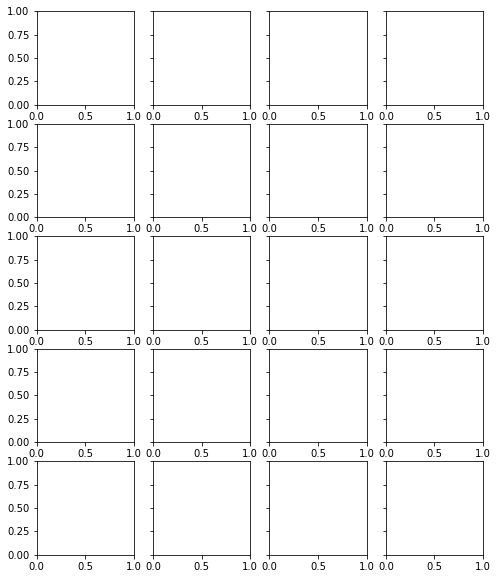

In [5]:
# Plot time-averaged u, v, u'w' and v'w' profiles.
alpha = 0.25
uvma = 0.18
uvmi = -uvma
uwvwma = 0.5
uwvwmi = -uwvwma

bb = dict(boxstyle='round', ec='k', fc='w')
zmi, zma = 0, 32

figsize = (8, 10)
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=figsize, sharey=True)

_ = system("rm %s"%tmpnc)

In [6]:
#----- OC25SA
fc = "OC25SA-cache.npz"
if isfile(fc):
    d = np.load(fc)
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = d["us"], d["vs"], d["un"], d["vn"], d["uws"], d["vws"], d["uwn"], d["vwn"], d["CI95us"], d["CI95vs"], d["CI95un"], d["CI95vn"], d["CI95uws"], d["CI95vws"], d["CI95uwn"], d["CI95vwn"], d["z"], d["t"]
else:
    ds1 = open_dataset(head+'OC25SA-Ad1rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, 17)))#.interpolate_na("t")
    ds2 = open_dataset(head+'OC25SA-Ad2rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, 17)))#.interpolate_na("t")
    ds2["z"] = ds1["z"]
    ds = concat((ds1, ds2), dim='t')
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = average_profiles(ds, *args, nblks=nblks)
    d = dict(us=us, vs=vs, un=un, vn=vn, uws=uws, vws=vws, uwn=uwn, vwn=vwn, CI95us=CI95us, CI95vs=CI95vs, CI95un=CI95un, CI95vn=CI95vn, CI95uws=CI95uws, CI95vws=CI95vws, CI95uwn=CI95uwn, CI95vwn=CI95vwn, z=z, t=t)
    np.savez(fc, **d)

In [7]:
ax[0][0].plot(un, z, 'r--', label=r"$u$")
ax[0][0].fill_betweenx(z, un-CI95un, x2=(un+CI95un), alpha=alpha, facecolor='r')
ax[0][0].plot(vn, z, 'r', label=r"$v$")
ax[0][0].fill_betweenx(z, vn-CI95vn, x2=(vn+CI95vn), alpha=alpha, facecolor='r')
ax[0][1].plot(uwn*rho0, z, 'r--', label=r"$\rho\overline{u'w'}$")
ax[0][1].fill_betweenx(z, (uwn-CI95uwn)*rho0, x2=(uwn*rho0+CI95uwn*rho0), alpha=alpha, facecolor='r')
ax[0][1].plot(vwn*rho0, z, 'r', label=r"$\rho\overline{v'w'}$")
ax[0][1].fill_betweenx(z, (vwn-CI95vwn)*rho0, x2=(vwn*rho0+CI95vwn*rho0), alpha=alpha, facecolor='r')
plt.show()

ax[0][2].plot(us, z, 'b--', label=r"$u$")
ax[0][2].fill_betweenx(z, us-CI95us, x2=(us+CI95us), alpha=alpha, facecolor='b')
ax[0][2].plot(vs, z, 'b', label=r"$v$")
ax[0][2].fill_betweenx(z, vs-CI95vs, x2=(vs+CI95vs), alpha=alpha, facecolor='b')
ax[0][3].plot(uws*rho0, z, 'b--', label=r"$\rho\overline{u'w'}$")
ax[0][3].fill_betweenx(z, (uws-CI95uws)*rho0, x2=(uws*rho0+CI95uws*rho0), alpha=alpha, facecolor='b')
ax[0][3].plot(vws*rho0, z, 'b', label=r"$\rho\overline{v'w'}$")
ax[0][3].fill_betweenx(z, (vws-CI95vws)*rho0, x2=(vws*rho0+CI95vws*rho0), alpha=alpha, facecolor='b')
plt.show()

_ = system("rm %s"%tmpnc)

In [8]:
#----- OC25SB
fc = "OC25SB-cache.npz"
if isfile(fc):
    d = np.load(fc)
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = d["us"], d["vs"], d["un"], d["vn"], d["uws"], d["vws"], d["uwn"], d["vwn"], d["CI95us"], d["CI95vs"], d["CI95un"], d["CI95vn"], d["CI95uws"], d["CI95vws"], d["CI95uwn"], d["CI95vwn"], d["z"], d["t"]
else:
    ds = open_dataset(head+'OC25SB-Ad2rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, 17)))#.interpolate_na("t")
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = average_profiles(ds, *args, nblks=nblks)
    d = dict(us=us, vs=vs, un=un, vn=vn, uws=uws, vws=vws, uwn=uwn, vwn=vwn, CI95us=CI95us, CI95vs=CI95vs, CI95un=CI95un, CI95vn=CI95vn, CI95uws=CI95uws, CI95vws=CI95vws, CI95uwn=CI95uwn, CI95vwn=CI95vwn, z=z, t=t)
    np.savez(fc, **d)

In [9]:
ax[1][0].plot(un[1:], z[1:], 'r--', label=r"$u$")
ax[1][0].fill_betweenx(z[2:], un[2:]-CI95un[2:], x2=(un[2:]+CI95un[2:]), alpha=alpha, facecolor='r')
ax[1][0].plot(vn[1:], z[1:], 'r', label=r"$v$")
ax[1][0].fill_betweenx(z[2:], vn[2:]-CI95vn[2:], x2=(vn[2:]+CI95vn[2:]), alpha=alpha, facecolor='r')
ax[1][1].plot(uwn*rho0, z, 'r--', label=r"$\rho\overline{u'w'}$")
ax[1][1].fill_betweenx(z, (uwn-CI95uwn)*rho0, x2=(uwn*rho0+CI95uwn*rho0), alpha=alpha, facecolor='r')
ax[1][1].plot(vwn*rho0, z, 'r', label=r"$\rho\overline{v'w'}$")
ax[1][1].fill_betweenx(z, (vwn-CI95vwn)*rho0, x2=(vwn*rho0+CI95vwn*rho0), alpha=alpha, facecolor='r')
plt.show()

ax[1][2].plot(us, z, 'b--', label=r"$u$")
ax[1][2].fill_betweenx(z, us-CI95us, x2=(us+CI95us), alpha=alpha, facecolor='b')
ax[1][2].plot(vs, z, 'b', label=r"$v$")
ax[1][2].fill_betweenx(z, vs-CI95vs, x2=(vs+CI95vs), alpha=alpha, facecolor='b')
ax[1][3].plot(uws*rho0, z, 'b--', label=r"$\rho\overline{u'w'}$")
ax[1][3].fill_betweenx(z, (uws-CI95uws)*rho0, x2=(uws*rho0+CI95uws*rho0), alpha=alpha, facecolor='b')
ax[1][3].plot(vws*rho0, z, 'b', label=r"$\rho\overline{v'w'}$")
ax[1][3].fill_betweenx(z, (vws-CI95vws)*rho0, x2=(vws*rho0+CI95vws*rho0), alpha=alpha, facecolor='b')
plt.show()

_ = system("rm %s"%tmpnc)

In [10]:
#----- OC25M
fc = "OC25M-cache.npz"
if isfile(fc):
    d = np.load(fc)
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = d["us"], d["vs"], d["un"], d["vn"], d["uws"], d["vws"], d["uwn"], d["vwn"], d["CI95us"], d["CI95vs"], d["CI95un"], d["CI95vn"], d["CI95uws"], d["CI95vws"], d["CI95uwn"], d["CI95vwn"], d["z"], d["t"]
else:
    ds1 = open_dataset(head+'OC25M-Ad1rs5-10min_ensembles-nobinmap.nc').sel(dict(z=slice(0, 17)))#.interpolate_na("t")
    ds2 = open_dataset(head+'OC25M-Ad2rs5-10min_ensembles-nobinmap.nc').sel(dict(z=slice(0, 17)))#.interpolate_na("t")
    ds2["z"] = ds1["z"]
    ds = concat((ds1, ds2), dim='t')
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = average_profiles(ds, *args, nblks=nblks, notilt=True)
    d = dict(us=us, vs=vs, un=un, vn=vn, uws=uws, vws=vws, uwn=uwn, vwn=vwn, CI95us=CI95us, CI95vs=CI95vs, CI95un=CI95un, CI95vn=CI95vn, CI95uws=CI95uws, CI95vws=CI95vws, CI95uwn=CI95uwn, CI95vwn=CI95vwn, z=z, t=t)
    np.savez(fc, **d)

In [11]:
ax[2][0].plot(un, z, 'r--', label=r"$u$")
ax[2][0].fill_betweenx(z, un-CI95un, x2=(un+CI95un), alpha=alpha, facecolor='r')
ax[2][0].plot(vn, z, 'r', label=r"$v$")
ax[2][0].fill_betweenx(z, vn-CI95vn, x2=(vn+CI95vn), alpha=alpha, facecolor='r')
ax[2][1].plot(uwn*rho0, z, 'r--', label=r"$\rho\overline{u'w'}$")
ax[2][1].fill_betweenx(z, (uwn-CI95uwn)*rho0, x2=(uwn*rho0+CI95uwn*rho0), alpha=alpha, facecolor='r')
ax[2][1].plot(vwn*rho0, z, 'r', label=r"$\rho\overline{v'w'}$")
ax[2][1].fill_betweenx(z, (vwn-CI95vwn)*rho0, x2=(vwn*rho0+CI95vwn*rho0), alpha=alpha, facecolor='r')
plt.show()

ax[2][2].plot(us, z, 'b--', label=r"$u$")
ax[2][2].fill_betweenx(z, us-CI95us, x2=(us+CI95us), alpha=alpha, facecolor='b')
ax[2][2].plot(vs, z, 'b', label=r"$v$")
ax[2][2].fill_betweenx(z, vs-CI95vs, x2=(vs+CI95vs), alpha=alpha, facecolor='b')
ax[2][3].plot(uws*rho0, z, 'b--', label=r"$\rho\overline{u'w'}$")
ax[2][3].fill_betweenx(z, (uws-CI95uws)*rho0, x2=(uws*rho0+CI95uws*rho0), alpha=alpha, facecolor='b')
ax[2][3].plot(vws*rho0, z, 'b', label=r"$\rho\overline{v'w'}$")
ax[2][3].fill_betweenx(z, (vws-CI95vws)*rho0, x2=(vws*rho0+CI95vws*rho0), alpha=alpha, facecolor='b')
plt.show()

_ = system("rm %s"%tmpnc)

In [12]:
#----- OC40S
fc = "OC40S-cache.npz"
if isfile(fc):
    d = np.load(fc)
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = d["us"], d["vs"], d["un"], d["vn"], d["uws"], d["vws"], d["uwn"], d["vwn"], d["CI95us"], d["CI95vs"], d["CI95un"], d["CI95vn"], d["CI95uws"], d["CI95vws"], d["CI95uwn"], d["CI95vwn"], d["z"], d["t"]
else:
    ds1 = open_dataset(head+'OC40S-Ad1rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, 30)))#.interpolate_na("t")
    ds2 = open_dataset(head+'OC40S-Ad2rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, 30)))#.interpolate_na("t")
    ds2["z"] = ds1["z"]
    ds = concat((ds1, ds2), dim='t')
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = average_profiles(ds, *args, nblks=nblks)
    d = dict(us=us, vs=vs, un=un, vn=vn, uws=uws, vws=vws, uwn=uwn, vwn=vwn, CI95us=CI95us, CI95vs=CI95vs, CI95un=CI95un, CI95vn=CI95vn, CI95uws=CI95uws, CI95vws=CI95vws, CI95uwn=CI95uwn, CI95vwn=CI95vwn, z=z, t=t)
    np.savez(fc, **d)

In [13]:
ax[3][0].plot(un, z, 'r--', label=r"$u$")
ax[3][0].fill_betweenx(z, un-CI95un, x2=(un+CI95un), alpha=alpha, facecolor='r')
ax[3][0].plot(vn, z, 'r', label=r"$v$")
ax[3][0].fill_betweenx(z, vn-CI95vn, x2=(vn+CI95vn), alpha=alpha, facecolor='r')
ax[3][1].plot(uwn*rho0, z, 'r--', label=r"$\rho\overline{u'w'}$")
ax[3][1].fill_betweenx(z, (uwn-CI95uwn)*rho0, x2=(uwn*rho0+CI95uwn*rho0), alpha=alpha, facecolor='r')
ax[3][1].plot(vwn*rho0, z, 'r', label=r"$\rho\overline{v'w'}$")
ax[3][1].fill_betweenx(z, (vwn-CI95vwn)*rho0, x2=(vwn*rho0+CI95vwn*rho0), alpha=alpha, facecolor='r')
plt.show()

ax[3][2].plot(us, z, 'b--', label=r"$u$")
ax[3][2].fill_betweenx(z, us-CI95us, x2=(us+CI95us), alpha=alpha, facecolor='b')
ax[3][2].plot(vs, z, 'b', label=r"$v$")
ax[3][2].fill_betweenx(z, vs-CI95vs, x2=(vs+CI95vs), alpha=alpha, facecolor='b')
ax[3][3].plot(uws*rho0, z, 'b--', label=r"$\rho\overline{u'w'}$")
ax[3][3].fill_betweenx(z, (uws-CI95uws)*rho0, x2=(uws*rho0+CI95uws*rho0), alpha=alpha, facecolor='b')
ax[3][3].plot(vws*rho0, z, 'b', label=r"$\rho\overline{v'w'}$")
ax[3][3].fill_betweenx(z, (vws-CI95vws)*rho0, x2=(vws*rho0+CI95vws*rho0), alpha=alpha, facecolor='b')
plt.show()

_ = system("rm %s"%tmpnc)

In [14]:
#----- OC40N
fc = "OC40N-cache.npz"
if isfile(fc):
    d = np.load(fc)
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = d["us"], d["vs"], d["un"], d["vn"], d["uws"], d["vws"], d["uwn"], d["vwn"], d["CI95us"], d["CI95vs"], d["CI95un"], d["CI95vn"], d["CI95uws"], d["CI95vws"], d["CI95uwn"], d["CI95vwn"], d["z"], d["t"]
else:
    ds = open_dataset(head+'OC40N-Ad1rs5-10min_ensembles-nobinmap-bias-corrected.nc').sel(dict(z=slice(0, 30)))#.interpolate_na("t")
    us, vs, un, vn, uws, vws, uwn, vwn, CI95us, CI95vs, CI95un, CI95vn, CI95uws, CI95vws, CI95uwn, CI95vwn, z, t = average_profiles(ds, *args, nblks=nblks)
    d = dict(us=us, vs=vs, un=un, vn=vn, uws=uws, vws=vws, uwn=uwn, vwn=vwn, CI95us=CI95us, CI95vs=CI95vs, CI95un=CI95un, CI95vn=CI95vn, CI95uws=CI95uws, CI95vws=CI95vws, CI95uwn=CI95uwn, CI95vwn=CI95vwn, z=z, t=t)
    np.savez(fc, **d)

In [15]:
ax[4][0].plot(un, z, 'r--', label=r"$u$")
ax[4][0].fill_betweenx(z, un-CI95un, x2=(un+CI95un), alpha=alpha, facecolor='r')
ax[4][0].plot(vn, z, 'r', label=r"$v$")
ax[4][0].fill_betweenx(z, vn-CI95vn, x2=(vn+CI95vn), alpha=alpha, facecolor='r')
ax[4][1].plot(uwn*rho0, z, 'r--', label=r"$\rho\overline{u'w'}$")
ax[4][1].fill_betweenx(z, (uwn-CI95uwn)*rho0, x2=(uwn*rho0+CI95uwn*rho0), alpha=alpha, facecolor='r')
ax[4][1].plot(vwn[1:]*rho0, z[1:], 'r', label=r"$\rho\overline{v'w'}$")
ax[4][1].fill_betweenx(z[1:], (vwn[1:]-CI95vwn[1:])*rho0, x2=(vwn[1:]*rho0+CI95vwn[1:]*rho0), alpha=alpha, facecolor='r')
plt.show()

ax[4][2].plot(us, z, 'b--', label=r"$u$")
ax[4][2].fill_betweenx(z, us-CI95us, x2=(us+CI95us), alpha=alpha, facecolor='b')
ax[4][2].plot(vs, z, 'b', label=r"$v$")
ax[4][2].fill_betweenx(z, vs-CI95vs, x2=(vs+CI95vs), alpha=alpha, facecolor='b')
ax[4][3].plot(uws*rho0, z, 'b--', label=r"$\rho\overline{u'w'}$")
ax[4][3].fill_betweenx(z, (uws-CI95uws)*rho0, x2=(uws*rho0+CI95uws*rho0), alpha=alpha, facecolor='b')
ax[4][3].plot(vws[1:]*rho0, z[1:], 'b', label=r"$\rho\overline{v'w'}$")
ax[4][3].fill_betweenx(z[1:], (vws[1:]-CI95vws[1:])*rho0, x2=(vws[1:]*rho0+CI95vws[1:]*rho0), alpha=alpha, facecolor='b')

In [16]:
ax[0][0].set_ylim(zmi, zma)
for nrow in range(5):
    ax[nrow][0].axvline(color='k', linestyle='--', alpha=0.2)
    ax[nrow][1].axvline(color='k', linestyle='--', alpha=0.2)
    ax[nrow][2].axvline(color='k', linestyle='--', alpha=0.2)
    ax[nrow][3].axvline(color='k', linestyle='--', alpha=0.2)

xtksuwvw = [-0.4, 0, 0.4]
for nrow in range(5):
    ax[nrow][0].set_xlim(uvmi, uvma)
    ax[nrow][2].set_xlim(uvmi, uvma)
    ax[nrow][1].set_xlim(uwvwmi, uwvwma)
    ax[nrow][3].set_xlim(uwvwmi, uwvwma)
    ax[nrow][1].xaxis.set_ticks(xtksuwvw)
    ax[nrow][3].xaxis.set_ticks(xtksuwvw)

ax[0][0].legend(frameon=False)
ax[0][1].legend(frameon=False)
ax[0][2].legend(frameon=False)
ax[0][3].legend(frameon=False)

ax[2][0].yaxis.set_ticks(np.arange(5, 35, 5))
ax[2][0].set_ylabel(r"Height above bottom [m]", fontweight='black', fontsize=14)
ax[0][0].xaxis.set_ticks_position('top')
ax[0][0].xaxis.set_label_position('top')
ax[0][1].xaxis.set_ticks_position('top')
ax[0][1].xaxis.set_label_position('top')
ax[0][2].xaxis.set_ticks_position('top')
ax[0][2].xaxis.set_label_position('top')
ax[0][3].xaxis.set_ticks_position('top')
ax[0][3].xaxis.set_label_position('top')

ax[4][0].set_xlabel(r"[m/s]", fontweight='black', fontsize=14)
ax[4][2].set_xlabel(r"[m/s]", fontweight='black', fontsize=14)
ax[4][1].set_xlabel(r"[Pa]", fontweight='black', fontsize=14)
ax[4][3].set_xlabel(r"[Pa]", fontweight='black', fontsize=14)

xt, yt = 1.05, 0.5
ax[0][3].text(xt, yt, r"OC25SA", fontsize=16, fontweight="black", rotation=-90, ha='center', va='center', transform=ax[0][3].transAxes)
ax[1][3].text(xt, yt, r"OC25SB", fontsize=16, fontweight="black", rotation=-90, ha='center', va='center', transform=ax[1][3].transAxes)
ax[2][3].text(xt, yt, r"OC25M", fontsize=16, fontweight="black", rotation=-90, ha='center', va='center', transform=ax[2][3].transAxes)
ax[3][3].text(xt, yt, r"OC40S", fontsize=16, fontweight="black", rotation=-90, ha='center', va='center', transform=ax[3][3].transAxes)
ax[4][3].text(xt, yt, r"OC40N", fontsize=16, fontweight="black", rotation=-90, ha='center', va='center', transform=ax[4][3].transAxes)

xt, yt = 1.0, 1.225
ax[0][0].text(xt, yt, r"Northward", color='r', fontsize=16, fontweight="black", ha='center', va='center', transform=ax[0][0].transAxes)
ax[0][2].text(xt, yt, r"Southward", color='b', fontsize=16, fontweight="black", ha='center', va='center', transform=ax[0][2].transAxes)

letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't']
letters.reverse()
xt, yt = 0.025, 0.05
for ncol in range(4):
    for nrow in range(5):
        axn = ax[nrow][ncol]
        axn.text(xt, yt, r"(%s)"%letters.pop(), fontweight="black", transform=axn.transAxes)
        axn.tick_params(right=True, left=True, top=True, bottom=True)

fig.subplots_adjust(wspace=0, hspace=0)

In [17]:
fig.savefig("fig13.png", dpi=300, bbox_inches="tight")
plt.show()

In [18]:
_ = system("rm %s"%tmpnc)